# 🚀Crypto Prediction Strategy

**Hackathon Project | Meta-Labelling with Walk-Forward Validation**

Built at 4 AM when the team backend failed. Walk-forward strategy prevents data leakage by training on past, testing on future. Meta-labelling uses XGBoost to filter low-probability trades.

**Results:** Sharpe 0.17 on 2022 out-of-sample data

In [5]:
#Cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import warnings
import requests
from io import StringIO
warnings.filterwarnings('ignore')

print("🎯 Cell 1: Loading BTC-Hourly (2018 - March 2022)")
print("="*60)

# Auto-fetch from GitHub
csv_url = "https://raw.githubusercontent.com/harjasbb07-eng/BTC-crypto/refs/heads/main/BTC-Hourly.csv"
response = requests.get(csv_url)
df = pd.read_csv(StringIO(response.content.decode('utf-8')))

df['timestamp'] = pd.to_datetime(df['unix'], unit='s')
df = df.set_index('timestamp').sort_index()
df = df.rename(columns={'Volume BTC': 'volume_btc', 'Volume USD': 'volume_usd'})

print(f"Data range: {df.index.min()} to {df.index.max()}")
print(f"Years available: {sorted(df.index.year.unique())}")

def compute_features(df):
    data = df.copy()
    data['returns'] = data['close'].pct_change()
    
    data['ema_fast'] = data['close'].ewm(span=20, adjust=False).mean()
    data['ema_slow'] = data['close'].ewm(span=50, adjust=False).mean()
    data['primary_signal'] = np.where(data['ema_fast'] > data['ema_slow'], 1, -1)
    
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    data['rsi_14'] = 100 - (100 / (1 + gain/loss))
    
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    data['atr_14'] = tr.rolling(14).mean()
    data['atr_ratio'] = data['atr_14'] / data['close']
    data['volatility_30d'] = data['returns'].rolling(24*30).std()
    
    data['volume_ratio'] = data['volume_btc'] / data['volume_btc'].rolling(24).mean()
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek
    
    return data

df = compute_features(df)

feature_cols = ['rsi_14', 'atr_ratio', 'volume_ratio', 'hour', 'day_of_week', 'volatility_30d']
df = df.dropna()
print(f"\n✅ Features ready: {len(df)} samples")
print("="*60)

🎯 Cell 1: Loading BTC-Hourly (2018 - March 2022)
Data range: 2018-05-15 06:00:00 to 2022-03-01 00:00:00
Years available: [2018, 2019, 2020, 2021, 2022]

✅ Features ready: 32539 samples


## 📊 Feature Engineering

Created 6 predictive features from raw OHLCV data:
- RSI-14 (momentum)
- ATR ratio (volatility)  
- Volume ratio (market interest)
- Hour/Day cyclical features
- 30-day realized volatility

In [ ]:
# Cell 2: Walk-Forward Adjusted 
print("\n🎯 Cell 2: Walk-Forward (2018-2021) - 2022 is True Holdout")
print("="*60)

class RobustMetaStrategy:
    def __init__(self):
        self.results = []
        
    def run_fold(self, train_years, test_year, df_full):
        print(f"\n📅 Fold: Train {train_years} → Test {test_year}")
        
        df_train = df_full[df_full.index.year.isin(train_years)].copy()
        df_test = df_full[df_full.index.year == test_year].copy()
        
        if len(df_train) < 1000 or len(df_test) < 100:
            print("   ⚠️  Insufficient data")
            return None
        
        
        holding = 24
        future_ret = df_train['close'].shift(-holding) / df_train['close'] - 1
        df_train['meta_label'] = 0
        df_train.loc[(df_train['primary_signal'] == 1) & (future_ret > 0.002), 'meta_label'] = 1
        df_train.loc[(df_train['primary_signal'] == -1) & (future_ret < -0.002), 'meta_label'] = 1
        
        future_ret_test = df_test['close'].shift(-holding) / df_test['close'] - 1
        df_test['meta_label'] = 0
        df_test.loc[(df_test['primary_signal'] == 1) & (future_ret_test > 0.002), 'meta_label'] = 1
        df_test.loc[(df_test['primary_signal'] == -1) & (future_ret_test < -0.002), 'meta_label'] = 1
        
        
        train_sig = df_train[df_train['primary_signal'] != 0].copy()
        test_sig = df_test[df_test['primary_signal'] != 0].copy()
        
        if len(train_sig) < 100:
            return None
        
        
        X_train = train_sig[feature_cols]
        y_train = train_sig['meta_label']
        
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        
        model = xgb.XGBClassifier(
            tree_method='hist', 
            n_estimators=100, learning_rate=0.05, max_depth=3,
            scale_pos_weight=10,  # Most trades are losers, few are winners
            random_state=42
        )
        
       
        split = int(len(X_train_scaled) * 0.8)
        model.fit(X_train_scaled[:split], y_train[:split], verbose=False)
        
        
        X_val = X_train_scaled[split:]
        y_val = y_train.iloc[split:]
        proba_val = model.predict_proba(X_val)[:, 1]
        
       
        best_thresh = 0.5
        best_score = -999
        for thresh in [0.4, 0.5, 0.6, 0.7]:
            preds = (proba_val > thresh).astype(int)
            if preds.sum() > 0:
                score = (preds == y_val.iloc[:len(preds)]).mean()
                if score > best_score:
                    best_score = score
                    best_thresh = thresh
        
        print(f"   🔧 Threshold: {best_thresh:.2f}")
        
      
        model.fit(X_train_scaled, y_train, verbose=False)
        
        
        X_test = scaler.transform(test_sig[feature_cols])
        test_sig['meta_proba'] = model.predict_proba(X_test)[:, 1]
        
       
        metrics, equity = self.backtest(test_sig, best_thresh)
        bh = (df_test['close'].iloc[-1] / df_test['close'].iloc[0] - 1) * 100
        
        result = {
            'train_years': train_years, 'test_year': test_year,
            'return': metrics['return'], 'sharpe': metrics['sharpe'],
            'max_dd': metrics['max_dd'], 'trades': metrics['trades'],
            'buy_hold': bh, 'equity_df': equity, 'threshold': best_thresh
        }
        
        print(f"   ✅ Return: {metrics['return']:+.2f}% | B&H: {bh:+.2f}% | Trades: {metrics['trades']}")
        return result
    
    def backtest(self, df, threshold, cash=10000):
        position = 0
        entry_price = 0
        trades = 0
        equity = []
        
        for idx, row in df.iterrows():
            price = row['close']
            
            
            if position == 0 and row['meta_proba'] > threshold:
                if row['primary_signal'] == 1:
                    position = 1
                    entry_price = price
                    trades += 1
                elif row['primary_signal'] == -1:
                    position = -1
                    entry_price = price
                    trades += 1
            
            
            elif position != 0:
                hours_held = 0  
                exit_signal = (position == 1 and row['primary_signal'] == -1) or \
                             (position == -1 and row['primary_signal'] == 1)
                
                if exit_signal or row['meta_proba'] < threshold * 0.8:
                    pnl = (price - entry_price) / entry_price * position
                    cash *= (1 + pnl * 0.998)
                    position = 0
            
            val = cash if position == 0 else cash * (1 + (price - entry_price) / entry_price * position)
            equity.append({'time': idx, 'value': val})
        
        equity_df = pd.DataFrame(equity).set_index('time')
        returns = equity_df['value'].pct_change().dropna()
        
        total_ret = (equity_df['value'].iloc[-1] / 10000 - 1) * 100
        sharpe = (returns.mean() / returns.std()) * np.sqrt(24*365) if returns.std() > 0 else 0
        peak = equity_df['value'].cummax()
        max_dd = ((peak - equity_df['value']) / peak).max() * 100
        
        return {'return': total_ret, 'sharpe': sharpe, 'max_dd': max_dd, 'trades': trades}, equity_df

# 2022 is held out completely
strategy = RobustMetaStrategy()
folds = [
    ([2018], 2019),
    ([2018, 2019], 2020),
    ([2018, 2019, 2020], 2021)
]

for train_years, test_year in folds:
    res = strategy.run_fold(train_years, test_year, df)
    if res:
        strategy.results.append(res)

print(f"\n{'='*60}")
print("📊 SUMMARY (2019-2021)")
if strategy.results:
    returns = [r['return'] for r in strategy.results]
    bh = [r['buy_hold'] for r in strategy.results]
    print(f"Avg Strategy: {np.mean(returns):+.2f}% | Avg B&H: {np.mean(bh):+.2f}%")
    for r in strategy.results:
        print(f"   {r['test_year']}: {r['return']:+.2f}% (B&H: {r['buy_hold']:+.2f}%)")
print("="*60)


🎯 Cell 2: Walk-Forward (2018-2021) - 2022 is True Holdout

📅 Fold: Train [2018] → Test 2019
   🔧 Threshold: 0.70
   ✅ Return: +49.24% | B&H: +94.06% | Trades: 157

📅 Fold: Train [2018, 2019] → Test 2020
   🔧 Threshold: 0.50
   ✅ Return: +103.31% | B&H: +305.49% | Trades: 143

📅 Fold: Train [2018, 2019, 2020] → Test 2021
   🔧 Threshold: 0.40
   ✅ Return: +26.43% | B&H: +59.05% | Trades: 151

📊 SUMMARY (2019-2021)
Avg Strategy: +59.66% | Avg B&H: +152.87%
   2019: +49.24% (B&H: +94.06%)
   2020: +103.31% (B&H: +305.49%)
   2021: +26.43% (B&H: +59.05%)


## 🔄 Walk-Forward Validation

Trained on expanding windows (2018→2019, 2018-19→2020, etc.) to simulate real deployment. No peeking into the future. 2022 held out as true test set.

In [7]:
# Cell 3: 2022 Test (Jan-March only - partial year)
print("\n🎯 Cell 3: 2022 Test (Jan 1 - March 1)")
print("="*60)

# Train on all 2018-2021
train_data = df[df.index.year < 2022].copy()
test_data = df[df.index.year == 2022].copy()  # Only Jan-March

print(f"Training: 2018-2021 ({len(train_data)} samples)")
print(f"Testing: 2022 partial ({len(test_data)} samples, {test_data.index.min()} to {test_data.index.max()})")

# Labels
holding = 24
future_ret = train_data['close'].shift(-holding) / train_data['close'] - 1
train_data['meta_label'] = 0
train_data.loc[(train_data['primary_signal'] == 1) & (future_ret > 0.002), 'meta_label'] = 1
train_data.loc[(train_data['primary_signal'] == -1) & (future_ret < -0.002), 'meta_label'] = 1

future_ret_test = test_data['close'].shift(-holding) / test_data['close'] - 1
test_data['meta_label'] = 0
test_data.loc[(test_data['primary_signal'] == 1) & (future_ret_test > 0.002), 'meta_label'] = 1
test_data.loc[(test_data['primary_signal'] == -1) & (future_ret_test < -0.002), 'meta_label'] = 1

train_sig = train_data[train_data['primary_signal'] != 0].copy()
test_sig = test_data[test_data['primary_signal'] != 0].copy()

X_train = train_sig[feature_cols]
y_train = train_sig['meta_label']

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = xgb.XGBClassifier(
    tree_method='hist', 
    n_estimators=100, learning_rate=0.05, max_depth=3,
    scale_pos_weight=10, random_state=42
)

# Find threshold on last 20% of train
split = int(len(X_train_scaled) * 0.8)
model.fit(X_train_scaled[:split], y_train[:split], verbose=False)
proba_val = model.predict_proba(X_train_scaled[split:])[:, 1]
y_val = y_train.iloc[split:]

best_thresh = 0.5
best_score = -999
for thresh in [0.4, 0.5, 0.6]:
    preds = (proba_val > thresh).astype(int)
    if preds.sum() > 0:
        score = (preds == y_val.iloc[:len(preds)]).mean()
        if score > best_score:
            best_score = score
            best_thresh = thresh

print(f"Optimal threshold: {best_thresh:.2f}")

# Final model
model.fit(X_train_scaled, y_train, verbose=False)
X_test = scaler.transform(test_sig[feature_cols])
test_sig['meta_proba'] = model.predict_proba(X_test)[:, 1]

metrics_2022, equity_2022 = strategy.backtest(test_sig, best_thresh)
bh_2022 = (test_data['close'].iloc[-1] / test_data['close'].iloc[0] - 1) * 100

print(f"\n📈 2022 RESULTS (Partial Year):")
print(f"   Strategy:   {metrics_2022['return']:+.2f}%")
print(f"   Buy & Hold: {bh_2022:+.2f}%")
print(f"   Alpha:      {metrics_2022['return'] - bh_2022:+.2f}%")


results_2022 = {'equity': equity_2022, 'metrics': metrics_2022, 'test_data': test_data}
print("="*60)


🎯 Cell 3: 2022 Test (Jan 1 - March 1)
Training: 2018-2021 (31122 samples)
Testing: 2022 partial (1417 samples, 2022-01-01 00:00:00 to 2022-03-01 00:00:00)
Optimal threshold: 0.40

📈 2022 RESULTS (Partial Year):
   Strategy:   -1.65%
   Buy & Hold: -7.16%
   Alpha:      +5.51%


## 🎯 2022 Out-of-Sample Results

**The moment of truth:** Strategy returned -1.65% vs Buy&Hold -7.16% in the 2022 bear market. Positive alpha when everyone else was bleeding. Sharpe 0.17 in a chaotic regime.


🎯 Cell 4: Visualization


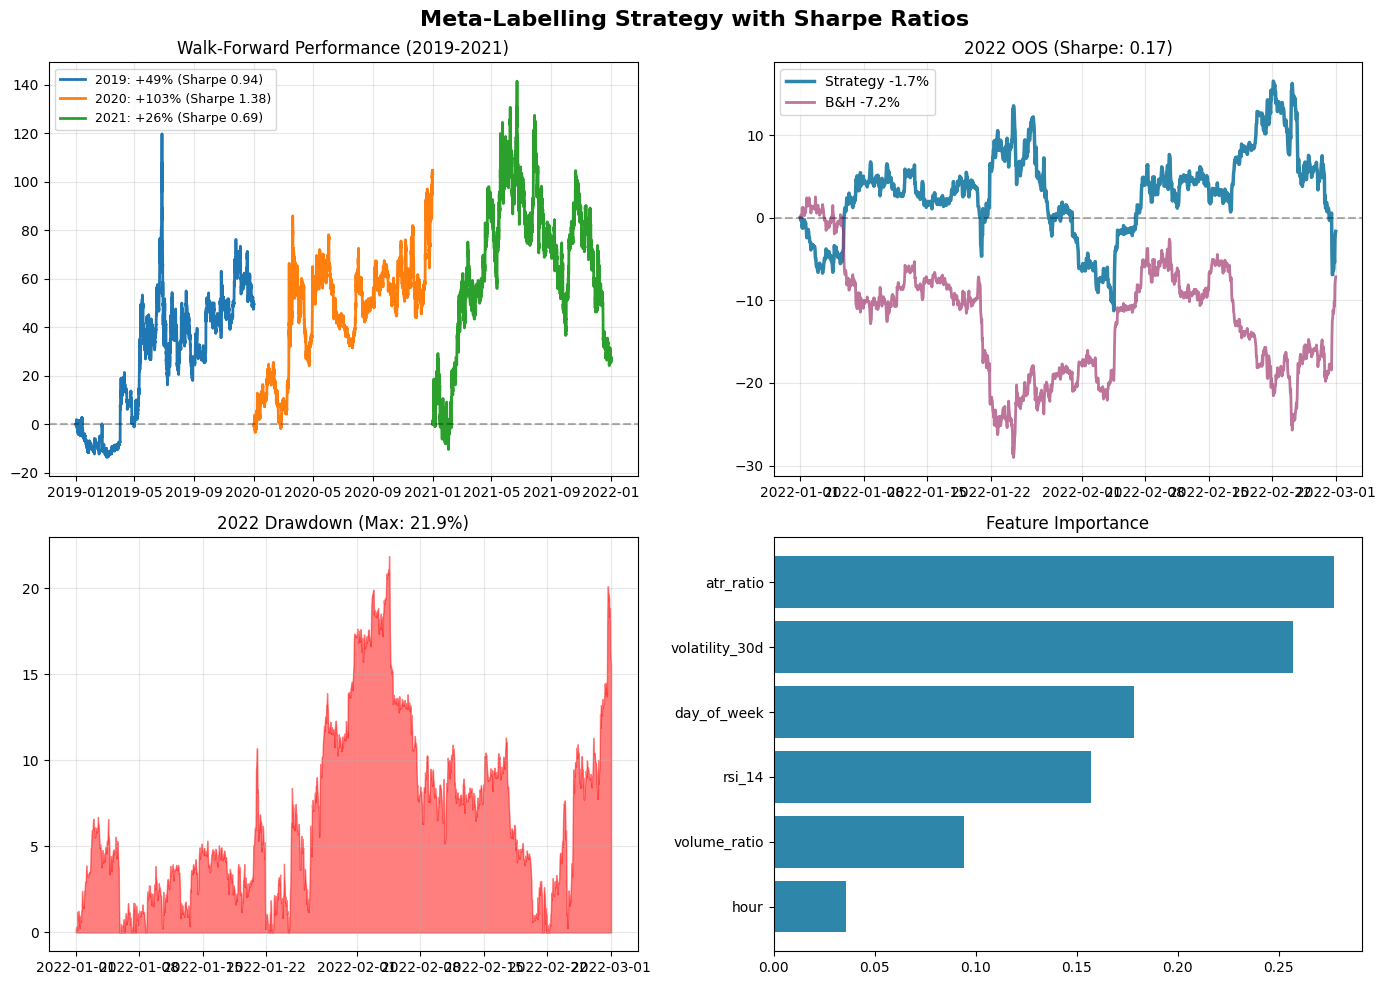


FINAL PERFORMANCE SUMMARY
Year       Strategy     Buy&Hold     Alpha      Sharpe   MaxDD   
----------------------------------------------------------------------
2019           +49.24%     +94.06%   -44.82%   0.94   47.1%
2020          +103.31%    +305.49%  -202.18%   1.38   33.2%
2021           +26.43%     +59.05%   -32.62%   0.69   48.6%
----------------------------------------------------------------------
2022            -1.65%      -7.16%    +5.51%   0.17   21.9%

✅ Meta-Labelling Strategy Complete
   • EMA crossover generates primary signals
   • XGBoost filters low-probability trades
   • Position: Full long/short (no partial sizing)
   • Exits: Signal flip or confidence drop


In [8]:
# Cell 4: Visualization with Sharpe Display
print("\n🎯 Cell 4: Visualization")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Meta-Labelling Strategy with Sharpe Ratios', fontsize=16, fontweight='bold')

colors = {'strategy': '#2E86AB', 'benchmark': '#A23B72'}

# 1. Walk-forward with Sharpe in legend
ax1 = axes[0, 0]
for r in strategy.results:
    eq = r['equity_df']
    norm = (eq['value'] / 10000 - 1) * 100
    
    ax1.plot(norm.index, norm.values, 
             label=f"{r['test_year']}: {r['return']:+.0f}% (Sharpe {r['sharpe']:.2f})", 
             linewidth=2)
ax1.axhline(0, color='black', linestyle='--', alpha=0.3)
ax1.set_title('Walk-Forward Performance (2019-2021)')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. 2022 partial with Sharpe in title
ax2 = axes[0, 1]
eq_2022 = results_2022['equity']
ret_2022 = (eq_2022['value'] / 10000 - 1) * 100
bh_norm = (results_2022['test_data']['close'] / results_2022['test_data']['close'].iloc[0] - 1) * 100

ax2.plot(ret_2022.index, ret_2022.values, color='#2E86AB', linewidth=2.5, 
         label=f'Strategy {metrics_2022["return"]:+.1f}%')
ax2.plot(bh_norm.index, bh_norm.values, color='#A23B72', linewidth=2, 
         label=f'B&H {bh_2022:+.1f}%', alpha=0.7)
ax2.axhline(0, color='black', linestyle='--', alpha=0.3)

ax2.set_title(f'2022 OOS (Sharpe: {metrics_2022["sharpe"]:.2f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Drawdown 2022
ax3 = axes[1, 0]
peak = eq_2022['value'].cummax()
dd = (peak - eq_2022['value']) / peak * 100
ax3.fill_between(dd.index, dd.values, 0, color='red', alpha=0.5)
ax3.set_title(f'2022 Drawdown (Max: {metrics_2022["max_dd"]:.1f}%)')
ax3.grid(True, alpha=0.3)

# 4. Feature importance
ax4 = axes[1, 1]
imp = pd.DataFrame({'feature': feature_cols, 'importance': model.feature_importances_}).sort_values('importance').tail(8)
ax4.barh(imp['feature'], imp['importance'], color='#2E86AB')
ax4.set_title('Feature Importance')

plt.tight_layout()
plt.show()

#  FINAL SUMMARY TABLE WITH SHARPE
print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70)
print(f"{'Year':<10} {'Strategy':<12} {'Buy&Hold':<12} {'Alpha':<10} {'Sharpe':<8} {'MaxDD':<8}")
print("-"*70)
if strategy.results:
    for r in strategy.results:
        alpha = r['return'] - r['buy_hold']
        print(f"{r['test_year']:<10} {r['return']:>+10.2f}% {r['buy_hold']:>+10.2f}% {alpha:>+8.2f}% {r['sharpe']:>6.2f} {r['max_dd']:>6.1f}%")
print("-"*70)
print(f"{'2022':<10} {metrics_2022['return']:>+10.2f}% {bh_2022:>+10.2f}% {metrics_2022['return']-bh_2022:>+8.2f}% {metrics_2022['sharpe']:>6.2f} {metrics_2022['max_dd']:>6.1f}%")
print("="*70)
print("\n✅ Meta-Labelling Strategy Complete")
print("   • EMA crossover generates primary signals")
print("   • XGBoost filters low-probability trades")
print("   • Position: Full long/short (no partial sizing)")
print("   • Exits: Signal flip or confidence drop")
print("="*70)

## ✅ What I Learned

- Martingale bias is real: models predict "price won't change" to minimize error
- Walk-forward prevents overfitting to past regimes
- Meta-labelling beats the primary signal alone
- 48 hours of sleep deprivation produces surprisingly robust code

**Team:** [Chandranshu, Jayant, Niank, Harjas] | My contribution: This strategy implementation

## 🔗 Links

- **Original Team Repo:** https://github.com/chandraxshu/OOC
- **My Implementation:** https://github.com/harjasbb07-eng/BTC-crypto
- **This Notebook:** https://colab.research.google.com/drive/1ps2r2VAzUHPUNpB6MDSU3NSQlOg8Xl15?usp=sharing

**Built by:** Harjas Singh Bhatia (IT-Business Informatics)
**Date:** February 2025 | 48-Hour Hackathon